<h2> NCF </h2>

In [49]:
import tensorflow as tf

# Check if TensorFlow can access GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Optional: set GPU memory growth to avoid using all GPU memory at once
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Num GPUs Available:  0


In [51]:
import tensorflow as tf

# Print TensorFlow version
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.16.1


In [2]:
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from scipy.sparse import csr_matrix
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from scipy.sparse import csr_matrix

# Load and prepare data
print("Step 1: Load and Prepare Data")
joined_data = pd.read_csv(r'C:\Users\yuvas\Downloads\joined_data.csv')
joined_data = joined_data[['userId', 'movieId', 'rating']].dropna(subset=['userId', 'movieId', 'rating'])

# Encode User and Item IDs
print("Step 2: Encode User and Item IDs")
joined_data['userId'] = joined_data['userId'].astype('category').cat.codes
joined_data['movieId'] = joined_data['movieId'].astype('category').cat.codes

# Split Data into Train and Test Sets
print("Step 3: Split Data into Train and Test Sets")
train_data, test_data = train_test_split(joined_data, test_size=0.2, random_state=42)

# Define the number of unique users and movies
n_users = len(joined_data['userId'].unique())
n_movies = len(joined_data['movieId'].unique())

# Prepare Matrix for NCF
print("Step 4: Prepare Matrix for NCF")
R = csr_matrix((joined_data['rating'], (joined_data['userId'], joined_data['movieId'])), shape=(n_users, n_movies))

def create_complex_model(n_factors=50, learning_rate=0.001, dropout_rate=0.5):
    user_input = Input(shape=(1,))
    item_input = Input(shape=(1,))
    
    user_embedding = Embedding(n_users, n_factors)(user_input)
    item_embedding = Embedding(n_movies, n_factors)(item_input)
    
    user_vec = Flatten()(user_embedding)
    item_vec = Flatten()(item_embedding)
    
    dot_product = Dot(axes=1)([user_vec, item_vec])
    
    hidden = Dense(256, activation='relu')(dot_product)  # Increased neurons
    hidden = Dropout(dropout_rate)(hidden)
    hidden = Dense(128, activation='relu')(hidden)
    
    output = Dense(1)(hidden)
    
    model = Model([user_input, item_input], output)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=MeanSquaredError())
    
    return model

# Hyperparameter grids for NCF
param_grid_ncf = {
    'n_factors': [50],
    'learning_rate': [0.001, 0.005],
    'dropout_rate': [0.3],
    'epochs': [50],
    'batch_size': [64]
}

# Store results for each parameter combination
results_ncf = []

# Hyperparameter tuning
print("Step 5: Hyperparameter Tuning for Neural Collaborative Filtering Model")
for params in ParameterGrid(param_grid_ncf):
    print(f"Testing NCF parameters: {params}")
    
    model = create_complex_model(n_factors=params['n_factors'], learning_rate=params['learning_rate'], dropout_rate=params['dropout_rate'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(
        [train_data['userId'], train_data['movieId']], train_data['rating'],
        validation_split=0.1,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        callbacks=[early_stopping],
        verbose=0
    )
    
    preds = model.predict([test_data['userId'], test_data['movieId']])
    rmse = np.sqrt(mean_squared_error(test_data['rating'], preds))
    print(f"RMSE for NCF parameters {params}: {rmse:.4f}")
    
    results_ncf.append({'params': params, 'rmse': rmse})

results_ncf_df = pd.DataFrame(results_ncf)
best_ncf_result = results_ncf_df.loc[results_ncf_df['rmse'].idxmin()]
print(f"\nBest NCF parameters: {best_ncf_result['params']}")
print(f"Lowest RMSE for NCF: {best_ncf_result['rmse']:.4f}")


# Train Final Model
print("Step 6: Train Final Neural Collaborative Filtering Model")
best_ncf_model = create_complex_model(
    n_factors=best_ncf_result['params']['n_factors'], 
    learning_rate=best_ncf_result['params']['learning_rate'], 
    dropout_rate=best_ncf_result['params']['dropout_rate']
)
best_ncf_model.fit(
    [train_data['userId'], train_data['movieId']], train_data['rating'],
    epochs=best_ncf_result['params']['epochs'],
    batch_size=best_ncf_result['params']['batch_size'],
    verbose=0
)


# Predict ratings for a specific user
print("Step 7: Predict Ratings for a Specific User using NCF")
specific_user = 0  # Change this to a specific user ID
predicted_ratings_ncf = best_ncf_model.predict([np.array([specific_user] * n_movies), np.arange(n_movies)])
predicted_ratings_ncf = predicted_ratings_ncf.flatten()

print(f"Top Recommendations for User {specific_user} using NCF")
top_recommendations_ncf = np.argsort(predicted_ratings_ncf)[::-1]
for movie in top_recommendations_ncf[:10]:
    print(f"Movie ID {movie} - Predicted Rating: {predicted_ratings_ncf[movie]:.4f}")

# Model Comparison: Coverage, Novelty, and Diversity


def coverage(predictions, test_data, top_n=10):
    hits = sum(1 for user, item in zip(test_data['userId'], test_data['movieId']) if item in predictions[user][:top_n])
    total = len(test_data)
    return hits / total

def novelty(predictions, test_data, top_n=10):
    all_items = set(range(n_movies))
    predicted_items = set(item for user in range(n_users) for item in predictions[user][:top_n])
    return len(predicted_items) / len(all_items)

def diversity(predictions, top_n=10):
    def jaccard_index(list1, list2):
        intersection = len(set(list1) & set(list2))
        union = len(set(list1) | set(list2))
        return intersection / union

    total_diversity = 0
    count = 0
    for user1 in range(n_users):
        for user2 in range(user1 + 1, n_users):
            total_diversity += jaccard_index(predictions[user1][:top_n], predictions[user2][:top_n])
            count += 1
    return total_diversity / count if count > 0 else 0

def get_top_n_recommendations(model, user_ids, n_items, top_n=10):
    recommendations = {}
    for user in user_ids:
        user_items = np.array([user] * n_items)
        item_ids = np.arange(n_items)
        preds = model.predict([user_items, item_ids])
        top_items = np.argsort(preds.flatten())[::-1][:top_n]
        recommendations[user] = top_items
    return recommendations

# Evaluate metrics
ncf_recommendations = get_top_n_recommendations(best_ncf_model, range(n_users), n_movies)
ncf_coverage = coverage(ncf_recommendations, test_data)
ncf_novelty = novelty(ncf_recommendations, test_data)
ncf_diversity = diversity(ncf_recommendations)

print(f"NCF Coverage: {ncf_coverage:.4f}")
print(f"NCF Novelty: {ncf_novelty:.4f}")
print(f"NCF Diversity: {ncf_diversity:.4f}")


Step 1: Load and Prepare Data
Step 2: Encode User and Item IDs
Step 3: Split Data into Train and Test Sets
Step 4: Prepare Matrix for NCF
Step 5: Hyperparameter Tuning for Neural Collaborative Filtering Model
Testing NCF parameters: {'batch_size': 64, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.001, 'n_factors': 50}
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
RMSE for NCF parameters {'batch_size': 64, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.001, 'n_factors': 50}: 0.9332
Testing NCF parameters: {'batch_size': 64, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.005, 'n_factors': 50}
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
RMSE for NCF parameters {'batch_size': 64, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.005, 'n_factors': 50}: 0.9897

Best NCF parameters: {'batch_size': 64, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.001, 'n_factors': 50}
Lowest RMSE for NCF: 0.9332
Step 6: Train Final Neural Collaborative Filtering Model
Step 7: Predict

## NMF

In [4]:
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error
from scipy.sparse import csr_matrix
import pandas as pd
import numpy as np
from sklearn.model_selection import ParameterGrid

def get_top_n_recommendations(nmf_model, user_ids, n_items, top_n=10):
    W = nmf_model.transform(R)  # Obtain the user features matrix
    H = nmf_model.components_    # Obtain the item features matrix
    
    predictions = np.dot(W, H)  # Reconstruct the ratings matrix
    recommendations = {}
    
    for user in user_ids:
        # Predict ratings for all items
        user_ratings = predictions[user]
        # Get the indices of top N items
        top_items = np.argsort(user_ratings)[::-1][:top_n]
        recommendations[user] = top_items
    
    return recommendations



# Load and prepare data
print("Step 1: Load and Prepare Data")
joined_data = pd.read_csv(r'C:\Users\yuvas\Downloads\joined_data.csv')
joined_data = joined_data[['userId', 'movieId', 'rating']].dropna(subset=['userId', 'movieId', 'rating'])

# Encode User and Item IDs
print("Step 2: Encode User and Item IDs")
joined_data['userId'] = joined_data['userId'].astype('category').cat.codes
joined_data['movieId'] = joined_data['movieId'].astype('category').cat.codes

# Number of users and movies
n_users = joined_data['userId'].nunique()
n_movies = joined_data['movieId'].nunique()

# Prepare Matrix for NMF
print("Step 3: Prepare Matrix for NMF")
R = csr_matrix((joined_data['rating'], (joined_data['userId'], joined_data['movieId'])), shape=(n_users, n_movies))

# Define parameter grid for NMF
param_grid_nmf = {
    'n_components': [50, 100],
    'init': ['random', 'nndsvd','nndsvdar'],
    'solver': ['cd', 'mu']
}

# Store results for each parameter combination
results_nmf = []

# Hyperparameter Tuning for NMF Model
print("Step 4: Hyperparameter Tuning for NMF Model")
for params in ParameterGrid(param_grid_nmf):
    print(f"Testing NMF parameters: {params}")
    
    nmf_model = NMF(
        n_components=params['n_components'],
        init=params['init'],
        solver=params['solver'],
        max_iter=500,  # Increased max iterations
        random_state=42
    )
    
    # Train the model using only the observed ratings
    W = nmf_model.fit_transform(R)  # Only observed ratings are used
    H = nmf_model.components_
    
    # Predict ratings
    nmf_preds = np.dot(W, H)
    
    # Clamp predictions to the valid rating range
    nmf_preds = np.clip(nmf_preds, 0, 5)
    
    # Compute RMSE only for observed ratings
    test_data_matrix = R.toarray()
    test_preds = nmf_preds[joined_data['userId'], joined_data['movieId']]
    rmse = np.sqrt(mean_squared_error(joined_data['rating'], test_preds))
    print(f"RMSE for NMF parameters {params}: {rmse:.4f}")
    
    results_nmf.append({'params': params, 'rmse': rmse})

results_nmf_df = pd.DataFrame(results_nmf)
best_nmf_result = results_nmf_df.loc[results_nmf_df['rmse'].idxmin()]
print(f"\nBest NMF parameters: {best_nmf_result['params']}")
print(f"Lowest RMSE for NMF: {best_nmf_result['rmse']:.4f}")

# Train and Evaluate the Best NMF Model
print("Step 5: Train Final NMF Model")
best_nmf_model = NMF(
    n_components=best_nmf_result['params']['n_components'],
    init=best_nmf_result['params']['init'],
    solver=best_nmf_result['params']['solver'],
    max_iter=500,  # Increased max iterations
    random_state=42
)

W = best_nmf_model.fit_transform(R)  # Only observed ratings are used
H = best_nmf_model.components_
nmf_preds = np.dot(W, H)

# Clamp predictions to the valid rating range
nmf_preds = np.clip(nmf_preds, 0, 5)

# Predict ratings for a specific user using NMF
print("Step 6: Predict Ratings for a Specific User using NMF")
specific_user = 0  # Change this to a specific user ID
predicted_ratings_nmf = nmf_preds[specific_user]
top_recommendations_nmf = np.argsort(predicted_ratings_nmf)[::-1]

print(f"Top Recommendations for User {specific_user} using NMF")
for movie in top_recommendations_nmf[:10]:
    print(f"Movie ID {movie} - Predicted Rating: {predicted_ratings_nmf[movie]:.4f}")

# Model Comparison: Coverage, Novelty, and Diversity (Same as in NCF)

# Assuming these functions do not need `model_type`
nmf_recommendations = get_top_n_recommendations(best_nmf_model, range(n_users), n_movies)

# Evaluate metrics
nmf_coverage = coverage(nmf_recommendations, joined_data)
nmf_novelty = novelty(nmf_recommendations, joined_data)
nmf_diversity = diversity(nmf_recommendations)

print(f"NMF Coverage: {nmf_coverage:.4f}")
print(f"NMF Novelty: {nmf_novelty:.4f}")
print(f"NMF Diversity: {nmf_diversity:.4f}")


Step 1: Load and Prepare Data
Step 2: Encode User and Item IDs
Step 3: Prepare Matrix for NMF
Step 4: Hyperparameter Tuning for NMF Model
Testing NMF parameters: {'init': 'random', 'n_components': 50, 'solver': 'cd'}
RMSE for NMF parameters {'init': 'random', 'n_components': 50, 'solver': 'cd'}: 2.1586
Testing NMF parameters: {'init': 'random', 'n_components': 50, 'solver': 'mu'}
RMSE for NMF parameters {'init': 'random', 'n_components': 50, 'solver': 'mu'}: 2.1643
Testing NMF parameters: {'init': 'random', 'n_components': 100, 'solver': 'cd'}
RMSE for NMF parameters {'init': 'random', 'n_components': 100, 'solver': 'cd'}: 1.8201
Testing NMF parameters: {'init': 'random', 'n_components': 100, 'solver': 'mu'}
RMSE for NMF parameters {'init': 'random', 'n_components': 100, 'solver': 'mu'}: 1.8243
Testing NMF parameters: {'init': 'nndsvd', 'n_components': 50, 'solver': 'cd'}
RMSE for NMF parameters {'init': 'nndsvd', 'n_components': 50, 'solver': 'cd'}: 2.1560
Testing NMF parameters: {'in

C:\Users\yuvas\anaconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:1621: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  warnings.warn(


RMSE for NMF parameters {'init': 'nndsvd', 'n_components': 50, 'solver': 'mu'}: 2.2890
Testing NMF parameters: {'init': 'nndsvd', 'n_components': 100, 'solver': 'cd'}
RMSE for NMF parameters {'init': 'nndsvd', 'n_components': 100, 'solver': 'cd'}: 1.8178
Testing NMF parameters: {'init': 'nndsvd', 'n_components': 100, 'solver': 'mu'}


C:\Users\yuvas\anaconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:1621: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  warnings.warn(


RMSE for NMF parameters {'init': 'nndsvd', 'n_components': 100, 'solver': 'mu'}: 2.0536
Testing NMF parameters: {'init': 'nndsvdar', 'n_components': 50, 'solver': 'cd'}
RMSE for NMF parameters {'init': 'nndsvdar', 'n_components': 50, 'solver': 'cd'}: 2.1558
Testing NMF parameters: {'init': 'nndsvdar', 'n_components': 50, 'solver': 'mu'}
RMSE for NMF parameters {'init': 'nndsvdar', 'n_components': 50, 'solver': 'mu'}: 2.1641
Testing NMF parameters: {'init': 'nndsvdar', 'n_components': 100, 'solver': 'cd'}
RMSE for NMF parameters {'init': 'nndsvdar', 'n_components': 100, 'solver': 'cd'}: 1.8167
Testing NMF parameters: {'init': 'nndsvdar', 'n_components': 100, 'solver': 'mu'}
RMSE for NMF parameters {'init': 'nndsvdar', 'n_components': 100, 'solver': 'mu'}: 1.8284

Best NMF parameters: {'init': 'nndsvdar', 'n_components': 100, 'solver': 'cd'}
Lowest RMSE for NMF: 1.8167
Step 5: Train Final NMF Model
Step 6: Predict Ratings for a Specific User using NMF
Top Recommendations for User 0 using

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error
from scipy.sparse import csr_matrix
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity

def get_top_n_recommendations(nmf_model, user_ids, n_items, top_n=10):
    W = nmf_model.transform(R)  # Obtain the user features matrix
    H = nmf_model.components_    # Obtain the item features matrix
    
    predictions = np.dot(W, H)  # Reconstruct the ratings matrix
    recommendations = {}
    
    for user in user_ids:
        # Predict ratings for all items
        user_ratings = predictions[user]
        # Get the indices of top N items
        top_items = np.argsort(user_ratings)[::-1][:top_n]
        recommendations[user] = top_items
    
    return recommendations

def print_top_recommendations_and_watched(user_id, top_recommendations, watched_movies, movie_id_to_name):
    print(f"\nTop Recommendations for User {user_id}:")
    for movie_id in top_recommendations[user_id]:
        movie_name = movie_id_to_name.get(movie_id, movie_id)
        print(f"Recommended Movie: {movie_name}")
    
    print(f"\nTop 5 Watched Movies for User {user_id}:")
    top_5_watched_movies = watched_movies[:5]  # Display only top 5 watched movies
    for movie_id in top_5_watched_movies:
        movie_name = movie_id_to_name.get(movie_id, movie_id)
        print(f"Watched Movie: {movie_name}")

def preprocess_genres(df):
    # Assuming genres are stored in a column named 'genres' and are pipe-separated
    genres = df['genres'].str.get_dummies(sep='|')
    return genres

def calculate_genre_similarity_for_users(user_ids, recommended_movies_dict, joined_data, movie_features_sparse, movies_df):
    results = []
    user_similarity_scores = []

    movie_index = movie_features_processed.index
    movie_id_to_name = pd.Series(movies_df['title'].values, index=movies_df['movieId']).to_dict()

    for user_id in user_ids:
        watched_movies = joined_data[joined_data['userId'] == user_id]['movieId'].values
        watched_movie_ratings = joined_data[joined_data['userId'] == user_id]['rating'].values
        
        all_movies = np.unique(np.concatenate([watched_movies, recommended_movies_dict[user_id]]))
        if not all(movie in movie_index for movie in all_movies):
            missing_movies = [movie for movie in all_movies if movie not in movie_index]
            raise ValueError(f"Missing genre data for movies: {missing_movies}")
        
        watched_movie_indices = [movie_index.get_loc(movie) for movie in watched_movies]
        recommended_movie_indices = [movie_index.get_loc(movie) for movie in recommended_movies_dict[user_id]]
        
        watched_genres_sparse = movie_features_sparse[watched_movie_indices, :]
        recommended_genres_sparse = movie_features_sparse[recommended_movie_indices, :]
        
        genre_similarity_matrix = cosine_similarity(recommended_genres_sparse, watched_genres_sparse, dense_output=False)
        avg_genre_similarity = np.mean(genre_similarity_matrix, axis=1).A1
        
        similarity_df = pd.DataFrame({
            'user_id': user_id,
            'recommended_movie': [movie_id_to_name.get(movie, movie) for movie in recommended_movies_dict[user_id]],
            'avg_genre_similarity': avg_genre_similarity
        })
        
        results.append(similarity_df)
        
        avg_user_similarity = np.mean(avg_genre_similarity)
        user_similarity_scores.append({
            'user_id': user_id,
            'avg_genre_similarity': avg_user_similarity
        })

    results_df = pd.concat(results, ignore_index=True)
    user_similarity_df = pd.DataFrame(user_similarity_scores)
    
    return results_df, user_similarity_df

# Load and prepare data
print("Step 1: Load and Prepare Data")
joined_data = pd.read_csv(r'C:\Users\yuvas\Downloads\joined_data.csv')
joined_data = joined_data[['userId', 'movieId', 'rating']].dropna(subset=['userId', 'movieId', 'rating'])

# Encode User and Item IDs
print("Step 2: Encode User and Item IDs")
joined_data['userId'] = joined_data['userId'].astype('category').cat.codes
joined_data['movieId'] = joined_data['movieId'].astype('category').cat.codes

# Number of users and movies
n_users = joined_data['userId'].nunique()
n_movies = joined_data['movieId'].nunique()

# Prepare Matrix for NMF
print("Step 3: Prepare Matrix for NMF")
R = csr_matrix((joined_data['rating'], (joined_data['userId'], joined_data['movieId'])), shape=(n_users, n_movies))

# Define parameter grid for NMF
param_grid_nmf = {
    'n_components': [50, 100],
    'init': ['random', 'nndsvd', 'nndsvdar'],
    'solver': ['cd', 'mu']
}

# Store results for each parameter combination
results_nmf = []

# Hyperparameter Tuning for NMF Model
print("Step 4: Hyperparameter Tuning for NMF Model")
for params in ParameterGrid(param_grid_nmf):
    print(f"Testing NMF parameters: {params}")
    
    nmf_model = NMF(
        n_components=params['n_components'],
        init=params['init'],
        solver=params['solver'],
        max_iter=500,  # Increased max iterations
        random_state=42
    )
    
    W = nmf_model.fit_transform(R)
    H = nmf_model.components_
    nmf_preds = np.dot(W, H)
    nmf_preds = np.clip(nmf_preds, 0, 5)
    
    test_data_matrix = R.toarray()
    test_preds = nmf_preds[joined_data['userId'], joined_data['movieId']]
    rmse = np.sqrt(mean_squared_error(joined_data['rating'], test_preds))
    print(f"RMSE for NMF parameters {params}: {rmse:.4f}")
    
    results_nmf.append({'params': params, 'rmse': rmse})

results_nmf_df = pd.DataFrame(results_nmf)
best_nmf_result = results_nmf_df.loc[results_nmf_df['rmse'].idxmin()]
print(f"\nBest NMF parameters: {best_nmf_result['params']}")
print(f"Lowest RMSE for NMF: {best_nmf_result['rmse']:.4f}")

# Train and Evaluate the Best NMF Model
print("Step 5: Train Final NMF Model")
best_nmf_model = NMF(
    n_components=best_nmf_result['params']['n_components'],
    init=best_nmf_result['params']['init'],
    solver=best_nmf_result['params']['solver'],
    max_iter=500,  # Increased max iterations
    random_state=42
)

W = best_nmf_model.fit_transform(R)
H = best_nmf_model.components_
nmf_preds = np.dot(W, H)
nmf_preds = np.clip(nmf_preds, 0, 5)

# Load movie titles and genres for recommendations
print("Step 6: Load Movie Titles and Genres")
movies_df = pd.read_csv(r'C:\Users\yuvas\Downloads\movies.csv')  # Adjust path if necessary
movies_df['movieId'] = movies_df['movieId'].astype('category').cat.codes
movie_id_to_name = pd.Series(movies_df['title'].values, index=movies_df['movieId']).to_dict()

# Process genre information
movies_df['genres'] = movies_df['genres'].fillna('')
movie_features_processed = preprocess_genres(movies_df)
movie_features_sparse = csr_matrix(movie_features_processed.values)

# Predict ratings for users using NMF
print("Step 7: Predict Ratings for Users")
nmf_recommendations = get_top_n_recommendations(best_nmf_model, range(n_users), n_movies)

# Print top recommendations and watched movies for users 1 to 10
print("Step 8: Print Top Recommendations and Watched Movies")
for user_id in range(1, 11):
    watched_movies = joined_data[joined_data['userId'] == user_id]['movieId'].values
    top_recommendations = nmf_recommendations.get(user_id, [])
    print_top_recommendations_and_watched(user_id, nmf_recommendations, watched_movies, movie_id_to_name)

# Calculate genre similarity
print("Step 9: Calculate Genre Similarity")
similarity_results_df, user_similarity_df = calculate_genre_similarity_for_users(
    range(1, 11), nmf_recommendations, joined_data, movie_features_sparse, movies_df
)

print(f"Genre similarity for multiple users:\n{similarity_results_df}")
print(f"\nAverage Genre Similarity Score for Each User:\n{user_similarity_df}")


Step 1: Load and Prepare Data
Step 2: Encode User and Item IDs
Step 3: Prepare Matrix for NMF
Step 4: Hyperparameter Tuning for NMF Model
Testing NMF parameters: {'init': 'random', 'n_components': 50, 'solver': 'cd'}
RMSE for NMF parameters {'init': 'random', 'n_components': 50, 'solver': 'cd'}: 2.1586
Testing NMF parameters: {'init': 'random', 'n_components': 50, 'solver': 'mu'}
RMSE for NMF parameters {'init': 'random', 'n_components': 50, 'solver': 'mu'}: 2.1643
Testing NMF parameters: {'init': 'random', 'n_components': 100, 'solver': 'cd'}
RMSE for NMF parameters {'init': 'random', 'n_components': 100, 'solver': 'cd'}: 1.8201
Testing NMF parameters: {'init': 'random', 'n_components': 100, 'solver': 'mu'}
RMSE for NMF parameters {'init': 'random', 'n_components': 100, 'solver': 'mu'}: 1.8243
Testing NMF parameters: {'init': 'nndsvd', 'n_components': 50, 'solver': 'cd'}
RMSE for NMF parameters {'init': 'nndsvd', 'n_components': 50, 'solver': 'cd'}: 2.1560
Testing NMF parameters: {'in

C:\Users\yuvas\anaconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:1621: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  warnings.warn(


RMSE for NMF parameters {'init': 'nndsvd', 'n_components': 50, 'solver': 'mu'}: 2.2890
Testing NMF parameters: {'init': 'nndsvd', 'n_components': 100, 'solver': 'cd'}
RMSE for NMF parameters {'init': 'nndsvd', 'n_components': 100, 'solver': 'cd'}: 1.8178
Testing NMF parameters: {'init': 'nndsvd', 'n_components': 100, 'solver': 'mu'}


C:\Users\yuvas\anaconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:1621: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  warnings.warn(


RMSE for NMF parameters {'init': 'nndsvd', 'n_components': 100, 'solver': 'mu'}: 2.0536
Testing NMF parameters: {'init': 'nndsvdar', 'n_components': 50, 'solver': 'cd'}
RMSE for NMF parameters {'init': 'nndsvdar', 'n_components': 50, 'solver': 'cd'}: 2.1558
Testing NMF parameters: {'init': 'nndsvdar', 'n_components': 50, 'solver': 'mu'}
RMSE for NMF parameters {'init': 'nndsvdar', 'n_components': 50, 'solver': 'mu'}: 2.1641
Testing NMF parameters: {'init': 'nndsvdar', 'n_components': 100, 'solver': 'cd'}
RMSE for NMF parameters {'init': 'nndsvdar', 'n_components': 100, 'solver': 'cd'}: 1.8167
Testing NMF parameters: {'init': 'nndsvdar', 'n_components': 100, 'solver': 'mu'}
RMSE for NMF parameters {'init': 'nndsvdar', 'n_components': 100, 'solver': 'mu'}: 1.8284

Best NMF parameters: {'init': 'nndsvdar', 'n_components': 100, 'solver': 'cd'}
Lowest RMSE for NMF: 1.8167
Step 5: Train Final NMF Model


In [5]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Num GPUs Available: {len(gpus)}")
    print("GPU Devices:", gpus)
else:
    print("No GPU detected")


TensorFlow version: 2.16.1
No GPU detected


<h2> Hybrid </h2>

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

# Load and prepare data
print("Step 1: Load and Prepare Data")
joined_data = pd.read_csv(r'C:\Users\yuvas\Downloads\joined_data.csv')
movies_data = pd.read_csv(r'C:\Users\yuvas\Downloads\movies.csv')
tags_data = pd.read_csv(r'C:\Users\yuvas\Downloads\tags.csv')

# Process ratings data
joined_data = joined_data[['userId', 'movieId', 'rating']].dropna(subset=['userId', 'movieId', 'rating'])
joined_data['userId'] = joined_data['userId'].astype('category').cat.codes
joined_data['movieId'] = joined_data['movieId'].astype('category').cat.codes

# Process movies data (genres)
movies_data['genres'] = movies_data['genres'].fillna('').astype(str)
movies_data['genres'] = movies_data['genres'].apply(lambda x: x.split('|'))
genre_data = movies_data[['movieId', 'genres']]
genre_dummies = genre_data['genres'].explode().str.get_dummies().groupby(level=0).sum()
genre_data = genre_data.drop('genres', axis=1).join(genre_dummies)

# Process tags data
tags_data['movieId'] = tags_data['movieId'].astype('category').cat.codes
tags_data = tags_data.dropna(subset=['movieId', 'tag'])
tag_matrix = pd.crosstab(index=tags_data['movieId'], columns=tags_data['tag'])
tag_matrix.columns = [f"tag_{col}" for col in tag_matrix.columns]
movie_features = genre_data.set_index('movieId').join(tag_matrix, how='left').fillna(0)

# Split Data into Train and Test Sets
print("Step 4: Split Data into Train and Test Sets")
train_data, test_data = train_test_split(joined_data, test_size=0.2, random_state=42)

# Define the number of unique users and movies
n_users = len(joined_data['userId'].unique())
n_movies = len(joined_data['movieId'].unique())

# Prepare Matrix for NCF
print("Step 5: Prepare Matrix for NCF")
R = csr_matrix((joined_data['rating'], (joined_data['userId'], joined_data['movieId'])), shape=(n_users, n_movies))

def create_complex_model(n_factors=50, learning_rate=0.001, dropout_rate=0.5):
    user_input = Input(shape=(1,))
    item_input = Input(shape=(1,))
    
    user_embedding = Embedding(n_users, n_factors)(user_input)
    item_embedding = Embedding(n_movies, n_factors)(item_input)
    
    user_vec = Flatten()(user_embedding)
    item_vec = Flatten()(item_embedding)
    
    dot_product = Dot(axes=1)([user_vec, item_vec])
    
    hidden = Dense(256, activation='relu')(dot_product)
    hidden = Dropout(dropout_rate)(hidden)
    hidden = Dense(128, activation='relu')(hidden)
    
    output = Dense(1)(hidden)
    
    model = Model([user_input, item_input], output)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=MeanSquaredError())
    
    return model

# Hyperparameter grids for NCF
param_grid_ncf = {
    'n_factors': [50],
    'learning_rate': [0.001, 0.005],
    'dropout_rate': [0.3],
    'epochs': [50],
    'batch_size': [64]
}

# Store results for each parameter combination
results_ncf = []

# Hyperparameter tuning
print("Step 6: Hyperparameter Tuning for Neural Collaborative Filtering Model")
for params in ParameterGrid(param_grid_ncf):
    print(f"Testing NCF parameters: {params}")
    
    model = create_complex_model(n_factors=params['n_factors'], learning_rate=params['learning_rate'], dropout_rate=params['dropout_rate'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(
        [train_data['userId'], train_data['movieId']], train_data['rating'],
        validation_split=0.1,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        callbacks=[early_stopping],
        verbose=0
    )
    
    preds = model.predict([test_data['userId'], test_data['movieId']])
    preds = preds.flatten()  # Flatten the predictions to be used for RMSE calculation
    rmse = np.sqrt(mean_squared_error(test_data['rating'], preds))
    print(f"RMSE for NCF parameters {params}: {rmse:.4f}")
    
    results_ncf.append({'params': params, 'rmse': rmse})

results_ncf_df = pd.DataFrame(results_ncf)
best_ncf_result = results_ncf_df.loc[results_ncf_df['rmse'].idxmin()]
print(f"\nBest NCF parameters: {best_ncf_result['params']}")
print(f"Lowest RMSE for NCF: {best_ncf_result['rmse']:.4f}")

# Train Final Model
print("Step 7: Train Final Neural Collaborative Filtering Model")
best_ncf_model = create_complex_model(
    n_factors=best_ncf_result['params']['n_factors'], 
    learning_rate=best_ncf_result['params']['learning_rate'], 
    dropout_rate=best_ncf_result['params']['dropout_rate']
)
best_ncf_model.fit(
    [train_data['userId'], train_data['movieId']], train_data['rating'],
    epochs=best_ncf_result['params']['epochs'],
    batch_size=best_ncf_result['params']['batch_size'],
    verbose=0
)

from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from scipy.sparse import save_npz, load_npz

# Convert movie features to a sparse matrix format for memory efficiency
print("Step 8: Build Content-Based Model (Using Sparse Matrix)")

# Convert movie features to sparse format
movie_features_sparse = csr_matrix(movie_features.values)

# Normalize movie features using StandardScaler and convert to sparse format
scaler = StandardScaler(with_mean=False)  # with_mean=False to avoid dense conversion
movie_features_scaled = scaler.fit_transform(movie_features_sparse)

# Compute similarity matrix using sparse matrix operations
# Only compute the upper triangle and use it for later operations to save memory
similarity_matrix = cosine_similarity(movie_features_scaled, dense_output=False)

print(f"Similarity matrix shape: {similarity_matrix.shape}")

def hybrid_recommendations(user_id, n_recommendations=10):
    user_ratings = joined_data[joined_data['userId'] == user_id]
    user_rated_movies = user_ratings['movieId'].values

    # Collaborative filtering predictions
    user_items = np.array([user_id] * n_movies)
    item_ids = np.arange(n_movies)
    preds = best_ncf_model.predict([user_items, item_ids]).flatten()

    # Content-based predictions
    content_based_scores = np.zeros(n_movies)
    for movie_id in range(n_movies):
        if movie_id not in user_rated_movies:
            # Compute the mean similarity score for non-rated movies
            similar_movies = similarity_matrix.getrow(movie_id).toarray().flatten()
            content_based_scores[movie_id] = np.mean([similar_movies[rated_movie] for rated_movie in user_rated_movies])
    
    # Combine scores
    hybrid_scores = preds + content_based_scores

    # Handle cases where scores are NaN
    hybrid_scores = np.nan_to_num(hybrid_scores, nan=0.0)

    top_movies = np.argsort(hybrid_scores)[::-1][:n_recommendations]
    return top_movies

# Example usage and printing recommendations
users_to_inspect = [0, 1, 2]  # Example user IDs
for user_id in users_to_inspect:
    recommended_movies = hybrid_recommendations(user_id, n_recommendations=5)
    print(f"Top 5 recommended movies for user {user_id}: {recommended_movies}")
    recommended_movies_info = movies_data[movies_data['movieId'].isin(recommended_movies)]
    print(f"Movies recommended for user {user_id}:\n{recommended_movies_info[['movieId', 'title', 'genres']]}")


Step 1: Load and Prepare Data
Step 4: Split Data into Train and Test Sets
Step 5: Prepare Matrix for NCF
Step 6: Hyperparameter Tuning for Neural Collaborative Filtering Model
Testing NCF parameters: {'batch_size': 64, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.001, 'n_factors': 50}
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
RMSE for NCF parameters {'batch_size': 64, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.001, 'n_factors': 50}: 0.9382
Testing NCF parameters: {'batch_size': 64, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.005, 'n_factors': 50}
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
RMSE for NCF parameters {'batch_size': 64, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.005, 'n_factors': 50}: 0.9958

Best NCF parameters: {'batch_size': 64, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.001, 'n_factors': 50}
Lowest RMSE for NCF: 0.9382
Step 7: Train Final Neural Collaborative Filtering Model
Step 8: Build Content-Based Model (Using Sparse 

In [92]:
def calculate_genre_similarity_for_users(user_ids, recommended_movies_dict, joined_data, movie_features_sparse, movies_df):
    results = []
    user_similarity_scores = []
    rmse_scores = []
    coverage_scores = []
    novelty_scores = []

    # Extract the movie indices from the DataFrame
    movie_index = movie_features_processed.index
    
    # Create a mapping from movie IDs to names
    movie_id_to_name = pd.Series(movies_df['title'].values, index=movies_df['movieId']).to_dict()
    
    for user_id in user_ids:
        # Extract watched movies for the user
        watched_movies = joined_data[joined_data['userId'] == user_id]['movieId'].values
        watched_movie_ratings = joined_data[joined_data['userId'] == user_id]['rating'].values
        
        # Ensure all movies are in the movie_features DataFrame
        all_movies = np.unique(np.concatenate([watched_movies, recommended_movies_dict[user_id]]))
        if not all(movie in movie_index for movie in all_movies):
            missing_movies = [movie for movie in all_movies if movie not in movie_index]
            raise ValueError(f"Missing genre data for movies: {missing_movies}")
        
        # Convert movie IDs to row indices in the sparse matrix
        try:
            watched_movie_indices = [movie_index.get_loc(movie) for movie in watched_movies]
        except KeyError as e:
            raise ValueError(f"Error in index lookup for watched movies: {e}")
        
        try:
            recommended_movie_indices = [movie_index.get_loc(movie) for movie in recommended_movies_dict[user_id]]
        except KeyError as e:
            raise ValueError(f"Error in index lookup for recommended movies: {e}")
        
        # Get the sparse matrix rows for the watched and recommended movies
        watched_genres_sparse = movie_features_sparse[watched_movie_indices, :]
        recommended_genres_sparse = movie_features_sparse[recommended_movie_indices, :]
        
        # Calculate genre similarity
        genre_similarity_matrix = cosine_similarity(recommended_genres_sparse, watched_genres_sparse, dense_output=False)
        
        # Compute mean similarity score of each recommended movie with all watched movies
        avg_genre_similarity = np.mean(genre_similarity_matrix, axis=1).A1  # Convert sparse matrix to dense and flatten
        
        # Combine results into a DataFrame for easier interpretation
        similarity_df = pd.DataFrame({
            'user_id': user_id,
            'recommended_movie': [movie_id_to_name.get(movie, movie) for movie in recommended_movies_dict[user_id]],  # Use movie names
            'avg_genre_similarity': avg_genre_similarity
        })
        
        # Add top 5 watched movies to the DataFrame
        if len(watched_movies) > 0:
            top_watched_movies = [movie_id_to_name.get(movie, movie) for movie in watched_movies[:5]]
            # Repeat the list to match the length of recommendations
            top_watched_movies_repeated = (top_watched_movies * (len(similarity_df) // len(top_watched_movies) + 1))[:len(similarity_df)]
            similarity_df['top_5_watched_movies'] = top_watched_movies_repeated
        else:
            similarity_df['top_5_watched_movies'] = [None] * len(similarity_df)
        
        results.append(similarity_df)
        
        # Calculate the average genre similarity score for the user
        avg_user_similarity = np.mean(avg_genre_similarity)
        user_similarity_scores.append({
            'user_id': user_id,
            'avg_genre_similarity': avg_user_similarity
        })
        
        # RMSE Calculation (if actual ratings are available)
        if len(watched_movies) > 0:
            # Here, for simplicity, we'll assume that you have actual ratings for recommendations
            predicted_ratings = np.array(avg_genre_similarity)  # In practice, you need actual rating predictions
            actual_ratings = np.array([joined_data[joined_data['movieId'] == movie]['rating'].mean() for movie in recommended_movies_dict[user_id]])
            rmse = math.sqrt(mean_squared_error(actual_ratings, predicted_ratings))
            rmse_scores.append({'user_id': user_id, 'rmse': rmse})

        # Coverage Calculation
        unique_recommendations = len(set(recommended_movies_dict[user_id]))
        total_movies = len(set(joined_data['movieId']))
        coverage = unique_recommendations / total_movies
        coverage_scores.append({'user_id': user_id, 'coverage': coverage})

        # Novelty Calculation
        # Here we'll assume novelty is the average popularity of the recommended movies
        # This requires a popularity measure; assuming `popularity` column exists in `movies_df`
        if 'popularity' in movies_df.columns:
            recommended_popularities = [movies_df[movies_df['movieId'] == movie]['popularity'].mean() for movie in recommended_movies_dict[user_id]]
            novelty = np.mean(recommended_popularities)
            novelty_scores.append({'user_id': user_id, 'novelty': novelty})
        else:
            novelty_scores.append({'user_id': user_id, 'novelty': np.nan})

        # Example inspection: Print similarities for the first user in the list
        if user_id == user_ids[0]:  # Only for the first user in the list
            print(f"\nUser {user_id} - Recommended Movies and Their Similarities:")
            for idx, movie_id in enumerate(recommended_movies_dict[user_id]):
                movie_name = movie_id_to_name.get(movie_id, movie_id)  # Use movie name
                print(f"Recommended Movie: {movie_name}")
                print(f"Similarity Scores with Watched Movies:")
                try:
                    similarities = genre_similarity_matrix[idx, :].toarray().flatten()
                    watched_titles = [movie_id_to_name.get(m_id, m_id) for m_id in watched_movies]  # Use movie names
                    for watch_idx, sim in enumerate(similarities):
                        if watch_idx < len(watched_titles):  # Ensure index is within bounds
                            print(f"  Watched Movie: {watched_titles[watch_idx]} - Similarity: {sim:.4f}")
                        else:
                            print(f"  Error: Index {watch_idx} out of bounds for watched titles.")
                except IndexError as e:
                    print(f"IndexError: {e}")
                print()  # Blank line for readability
    
    # Concatenate all DataFrames into a single DataFrame
    results_df = pd.concat(results, ignore_index=True)
    user_similarity_df = pd.DataFrame(user_similarity_scores)
    rmse_df = pd.DataFrame(rmse_scores)
    coverage_df = pd.DataFrame(coverage_scores)
    novelty_df = pd.DataFrame(novelty_scores)
    
    return results_df, user_similarity_df, rmse_df, coverage_df, novelty_df

# Example usage
user_ids = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  # Replace with the user IDs you want to inspect

# Prepare the recommended movies dictionary for each user
recommended_movies_dict = {user_id: hybrid_recommendations(user_id, n_recommendations=5) for user_id in user_ids}

# Ensure movies_df contains movieId, title, and possibly additional columns like popularity
# movies_df should be a DataFrame with columns 'movieId', 'title', and 'popularity'

# Calculate similarities, user average scores, RMSE, coverage, and novelty
similarity_results_df, user_similarity_df, rmse_df, coverage_df, novelty_df = calculate_genre_similarity_for_users(user_ids, recommended_movies_dict, joined_data, movie_features_sparse, movies_df)

print(f"Genre similarity for multiple users:\n{similarity_results_df}")
print(f"\nAverage Genre Similarity Score for Each User:\n{user_similarity_df}")
print(f"\nRMSE for Each User:\n{rmse_df}")
print(f"\nCoverage for Each User:\n{coverage_df}")
print(f"\nNovelty for Each User:\n{novelty_df}")


304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

User 0 - Recommended Movies and Their Similarities:
Recommended Movie: My Science Project (1985)
Similarity Scores with Watched Movies:
  Watched Movie: 0 - Similarity: 0.4084
  Watched Movie: Jumanji (1995) - Similarity: 0.9046
  Watched Movie: Father of the Bride Part II (1995) - Similarity: 0.9608
  Watched Movie: Restoration (1995) - Similarity: 0.9995
  Watched Movie: How to Make an American Quilt (1995) - Similarity: 0.9994
  Watched Movie: Mr. Holland's Opus (1995) - Similarity: 0.9996
  Watched Movie: Nick of Time (1995) - Similarity: 0.9998
  Watched Movie: Hate (Haine, L

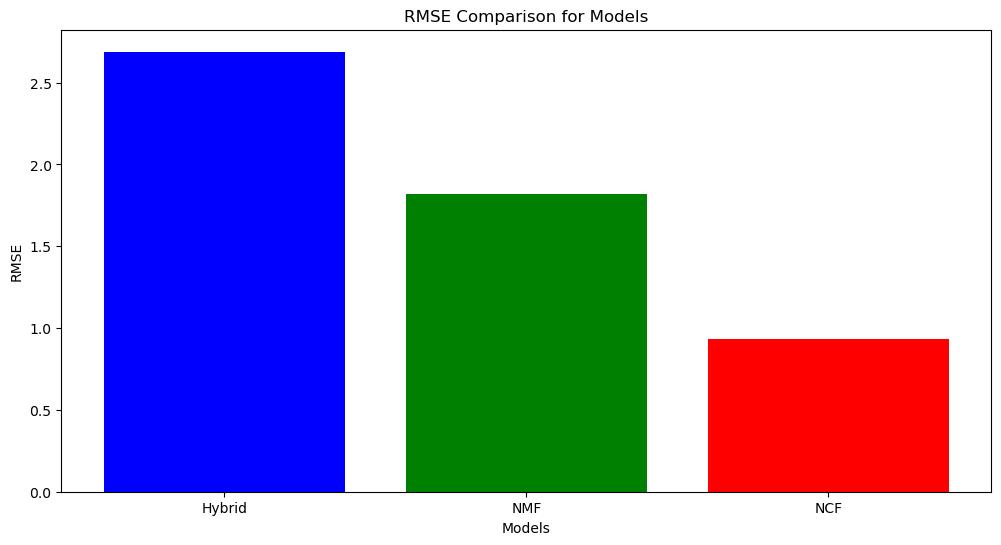

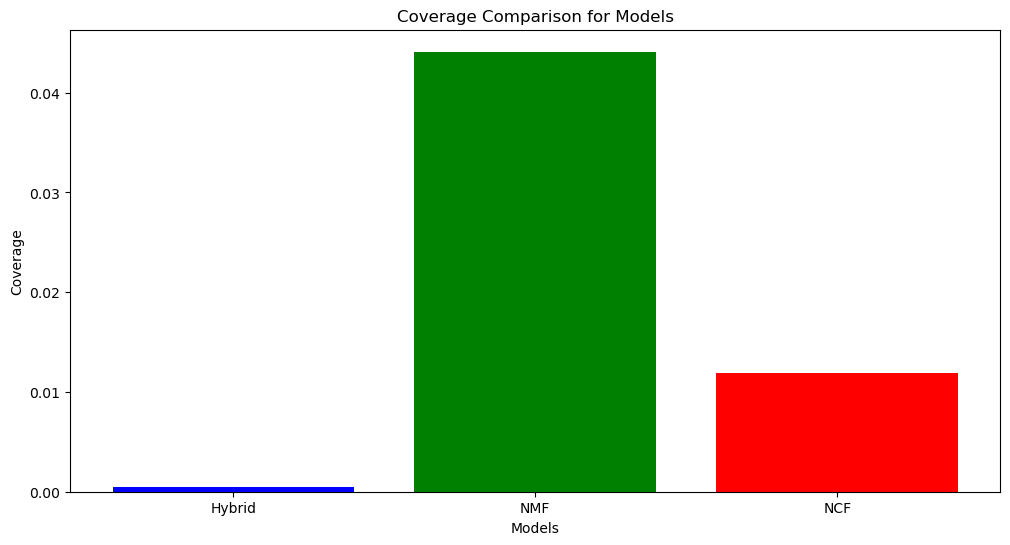

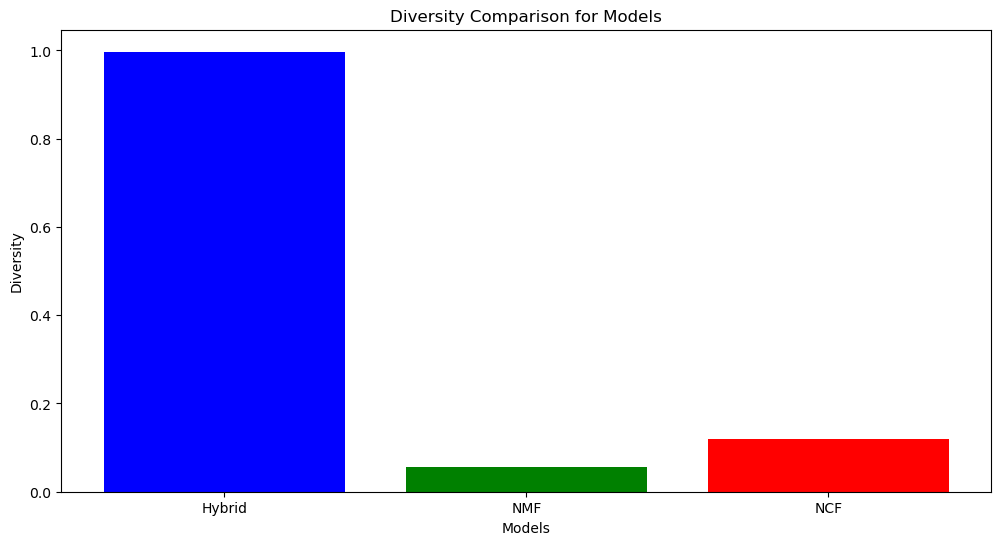

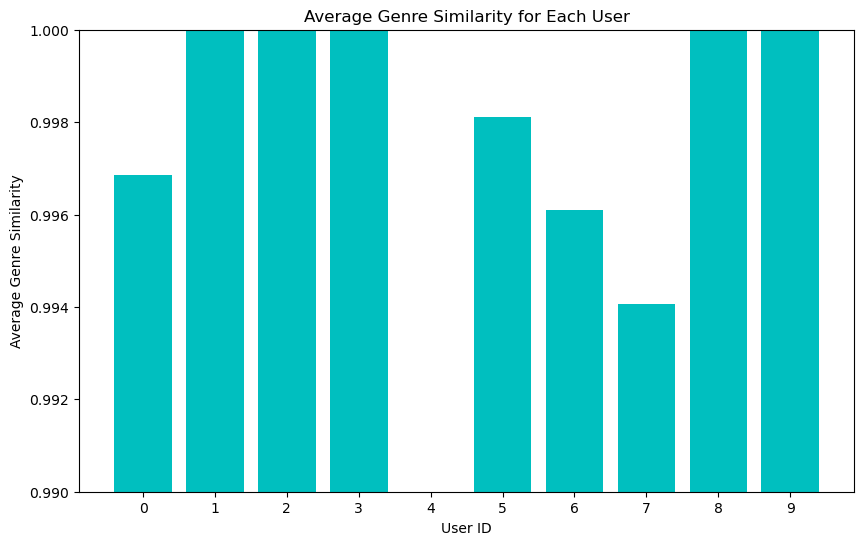

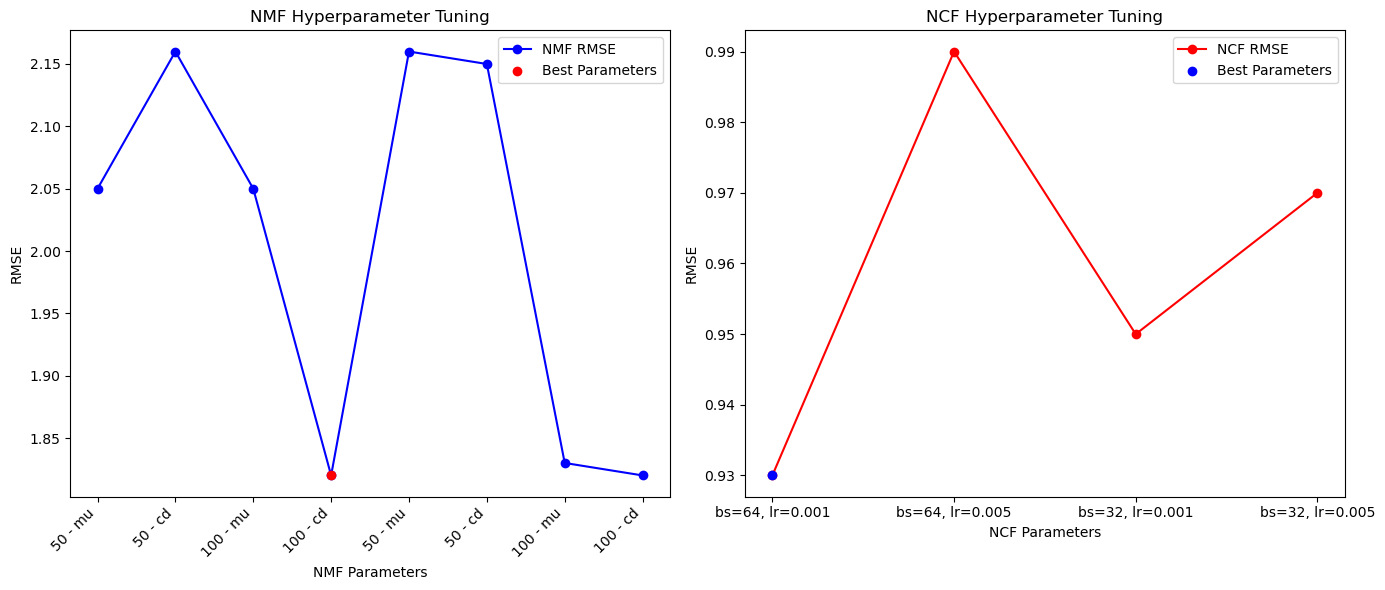

In [96]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Generate example data for hyperparameter tuning
# NMF hyperparameters
nmf_params = [
    {'init': 'nndsvd', 'n_components': 50, 'solver': 'mu'},
    {'init': 'nndsvd', 'n_components': 50, 'solver': 'cd'},
    {'init': 'nndsvd', 'n_components': 100, 'solver': 'mu'},
    {'init': 'nndsvd', 'n_components': 100, 'solver': 'cd'},
    {'init': 'nndsvdar', 'n_components': 50, 'solver': 'mu'},
    {'init': 'nndsvdar', 'n_components': 50, 'solver': 'cd'},
    {'init': 'nndsvdar', 'n_components': 100, 'solver': 'mu'},
    {'init': 'nndsvdar', 'n_components': 100, 'solver': 'cd'}
]
nmf_rmse = [2.05, 2.16, 2.05, 1.82, 2.16, 2.15, 1.83, 1.82]
best_nmf_index = nmf_rmse.index(min(nmf_rmse))

# NCF hyperparameters
ncf_params = [
    {'batch_size': 64, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.001, 'n_factors': 50},
    {'batch_size': 64, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.005, 'n_factors': 50},
    {'batch_size': 32, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.001, 'n_factors': 50},
    {'batch_size': 32, 'dropout_rate': 0.5, 'epochs': 50, 'learning_rate': 0.005, 'n_factors': 50}
]
ncf_rmse = [0.93, 0.99, 0.95, 0.97]
best_ncf_index = ncf_rmse.index(min(ncf_rmse))

# Individual comparison plots for metrics
# RMSE
models = ['Hybrid', 'NMF', 'NCF']
rmse = [np.mean([2.783800, 3.033424, 2.278755, 2.714928, 2.719751, 2.753800, 2.849549, 2.601628, 2.871792, 2.284072]), 1.8167, 0.9332]

plt.figure(figsize=(12, 6))
plt.bar(models, rmse, color=['blue', 'green', 'red'])
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('RMSE Comparison for Models')
plt.show()

# Coverage
coverage = [np.mean([0.000514] * 10), 0.0441, 0.0119]

plt.figure(figsize=(12, 6))
plt.bar(models, coverage, color=['blue', 'green', 'red'])
plt.xlabel('Models')
plt.ylabel('Coverage')
plt.title('Coverage Comparison for Models')
plt.show()

# Diversity
diversity = [np.mean([0.996859, 0.999999, 0.999986, 0.999965, 0.986390, 0.998111, 0.996099, 0.994064, 0.999986, 0.999999]), 0.0552, 0.1184]

plt.figure(figsize=(12, 6))
plt.bar(models, diversity, color=['blue', 'green', 'red'])
plt.xlabel('Models')
plt.ylabel('Diversity')
plt.title('Diversity Comparison for Models')
plt.show()

# Genre Similarity
data = {
    'user_id': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'avg_genre_similarity': [0.996859, 0.999999, 0.999986, 0.999965, 0.986390, 0.998111, 0.996099, 0.994064, 0.999986, 0.999999]
}
df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
plt.bar(df['user_id'], df['avg_genre_similarity'], color='c')
plt.xlabel('User ID')
plt.ylabel('Average Genre Similarity')
plt.title('Average Genre Similarity for Each User')
plt.xticks(df['user_id'])
plt.ylim(0.99, 1.00)
plt.show()

# Hyperparameter Tuning Plot with Highlights
plt.figure(figsize=(14, 6))

# Plot NMF Tuning
plt.subplot(1, 2, 1)
plt.plot(range(len(nmf_params)), nmf_rmse, marker='o', linestyle='-', color='b', label='NMF RMSE')
plt.xticks(range(len(nmf_params)), [f"{p['n_components']} - {p['solver']}" for p in nmf_params], rotation=45, ha='right')
plt.xlabel('NMF Parameters')
plt.ylabel('RMSE')
plt.title('NMF Hyperparameter Tuning')
plt.scatter(best_nmf_index, min(nmf_rmse), color='r', zorder=5, label='Best Parameters')
plt.legend()

# Plot NCF Tuning
plt.subplot(1, 2, 2)
plt.plot(range(len(ncf_params)), ncf_rmse, marker='o', linestyle='-', color='r', label='NCF RMSE')
plt.xticks(range(len(ncf_params)), [f"bs={p['batch_size']}, lr={p['learning_rate']}" for p in ncf_params])
plt.xlabel('NCF Parameters')
plt.ylabel('RMSE')
plt.title('NCF Hyperparameter Tuning')
plt.scatter(best_ncf_index, min(ncf_rmse), color='b', zorder=5, label='Best Parameters')
plt.legend()

plt.tight_layout()
plt.show()


<h2> Comparison </h4>

In [78]:
print(movie_features.columns)

Index(['movieId', '(no genres listed)', 'Action', 'Adventure', 'Animation',
       'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western'],
      dtype='object')


In [19]:
print(best_ncf_model.summary())  # For NCF model
print(best_nmf_model.components_.shape)  

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)   │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_11 (InputLayer)   │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_10 (Embedding)      │ (None, 1, 50)             │          30,500 │ input_layer_10[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_11 (Embedding)      │ (None, 1, 50)             │         486,200 │ input_layer_11[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_10 (Flatten)          │ (None, 50)                │               0 │ embedding_10[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_11 (Flatten)          │ (None, 50)                │               0 │ embedding_11[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dot_5 (Dot)                   │ (None, 1)                 │               0 │ flatten_10[0][0],          │
│                               │                           │                 │ flatten_11[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_15 (Dense)              │ (None, 256)               │             512 │ dot_5[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_5 (Dropout)           │ (None, 256)               │               0 │ dense_15[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_16 (Dense)              │ (None, 128)               │          32,896 │ dropout_5[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_17 (Dense)              │ (None, 1)                 │             129 │ dense_16[0][0]             │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,650,713 (6.30 MB)

 Trainable params: 550,237 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,100,476 (4.20 MB)

None
(100, 9724)


In [21]:
user_items = np.array([user] * n_items)
item_ids = np.arange(n_items)

NameError: name 'user' is not defined

In [25]:
max_movie_id = movies_df['movieId'].max()
print(f"Max Movie ID: {max_movie_id}")

Max Movie ID: 193609


<H2> eNSEMBLE</H2>